In [54]:
import torch
import torch.autograd.functional as F
import torch.distributions as dist

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

import pandas as pd
%matplotlib inline

# Retina display
%config InlineBackend.figure_format = 'retina'

In [38]:
from tueplots import bundles
plt.rcParams.update(bundles.beamer_moml())
#plt.rcParams.update(bundles.icml2022())


# Also add despine to the bundle using rcParams
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

# Increase font size to match Beamer template
plt.rcParams['font.size'] = 16
# Make background transparent
plt.rcParams['figure.facecolor'] = 'none'


In [39]:
import hamiltorch

In [40]:
hamiltorch.set_random_seed(123)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [41]:
device

device(type='cuda')

In [42]:
gt_distribution = torch.distributions.Normal(0, 1)

# Samples from the ground truth distribution
def sample_gt(n):
    return gt_distribution.sample((n,))

samples = sample_gt(1000)


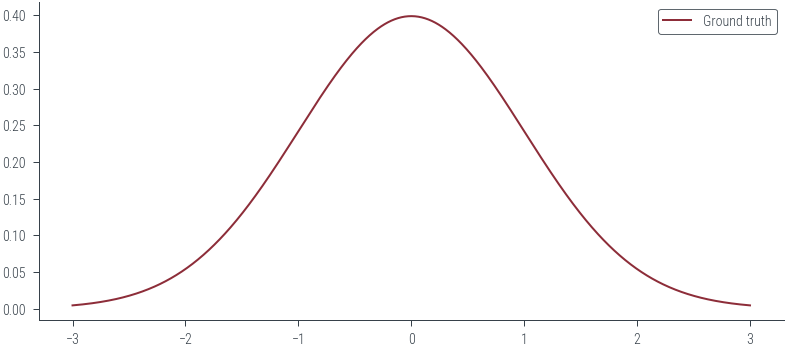

In [43]:
x_lin = torch.linspace(-3, 3, 1000)
y_lin = torch.exp(gt_distribution.log_prob(x_lin))

plt.plot(x_lin, y_lin, label='Ground truth')
plt.legend()

In [44]:
# Logprob function to be passed to Hamiltorch sampler
def logprob(x):
    return gt_distribution.log_prob(x)

In [45]:
logprob(torch.tensor([0.0]))

tensor([-0.9189])

In [46]:
# Initial state
x0 = torch.tensor([0.0])
num_samples = 5000
step_size = 0.3
num_steps_per_sample = 5
hamiltorch.set_random_seed(123)

In [47]:
params_hmc = hamiltorch.sample(log_prob_func=logprob, params_init=x0,  
                               num_samples=num_samples, step_size=step_size, 
                               num_steps_per_sample=num_steps_per_sample)

Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples   | Samples/sec
0d:00:00:07 | 0d:00:00:00 | #################### | 5000/5000 | 674.76       
Acceptance Rate 0.99


In [48]:
params_hmc = torch.tensor(params_hmc)

Text(0, 0.5, 'Parameter value')

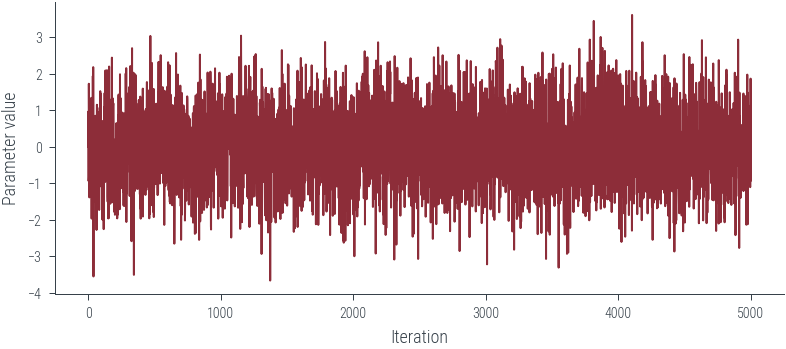

In [49]:
# Trace plot
plt.plot(params_hmc, label='Trace')
plt.xlabel('Iteration')
plt.ylabel('Parameter value')

Text(0, 0.5, 'Parameter value')

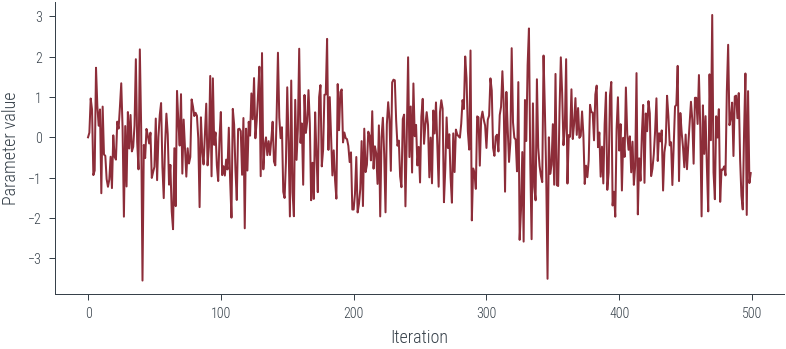

In [50]:
# view first 500 samples
plt.plot(params_hmc[:500], label='Trace')
plt.xlabel('Iteration')
plt.ylabel('Parameter value')


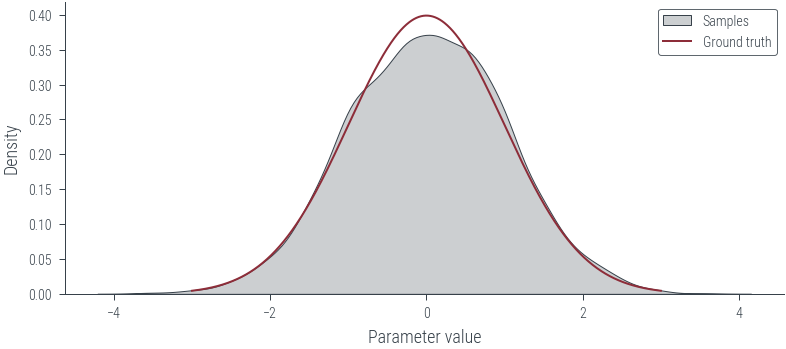

In [25]:
# KDE plot
import seaborn as sns
plt.figure()
sns.kdeplot(params_hmc.detach().numpy(), label='Samples', shade=True, color='C1')
plt.plot(x_lin, y_lin, label='Ground truth')
plt.xlabel('Parameter value')
plt.ylabel('Density')
plt.legend()

In [69]:
def plot_samples_gif(x_lin, y_lin, params_hmc, filename, frames=50):
    fig, ax = plt.subplots()
    plt.plot(x_lin, y_lin, label='Ground truth')
    scatter = ax.scatter([], [], color='C1', marker='x', s=100)

    # Function to update the animation
    def update(frame):
        scatter.set_offsets(np.array([[params_hmc[frame], 0]]))
        return scatter,

    # Create the animation
    anim = FuncAnimation(fig, update, frames=frames, blit=True)

    # Save the animation as a GIF or video file (you can change the filename and format)
    anim.save(filename, dpi=200)

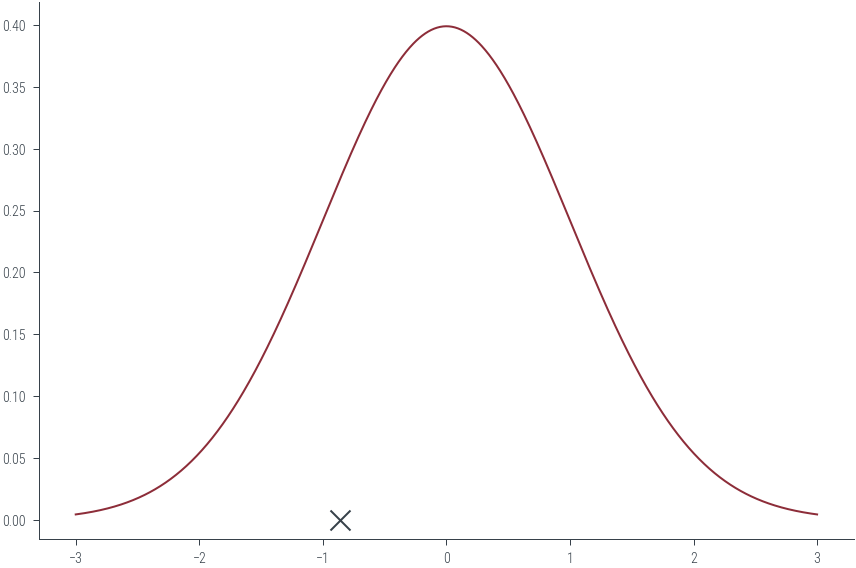

In [61]:
plot_samples_gif(x_lin, y_lin, params_hmc, '../figures/sampling/mcmc/hamiltorch-samples-normal.gif')

![](../figures/sampling/mcmc/hamiltorch-samples-normal.gif)

<AxesSubplot:ylabel='Density'>

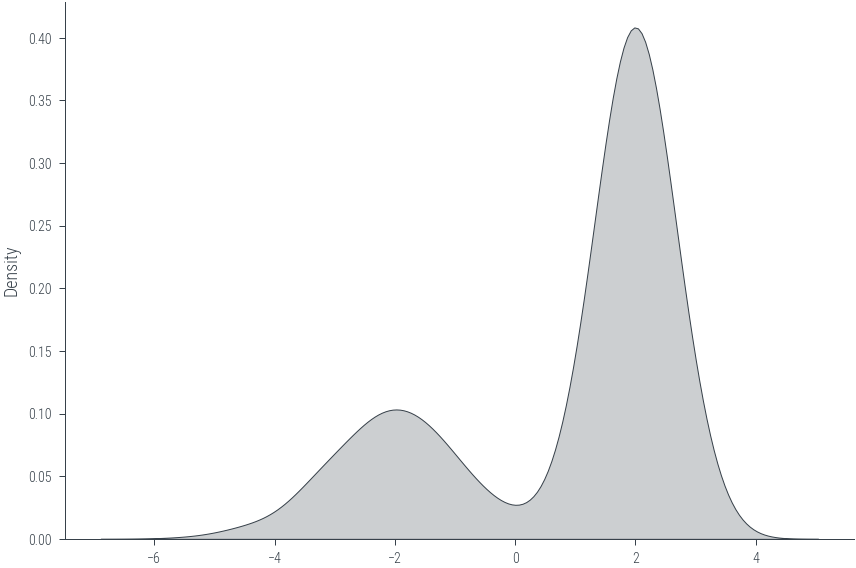

In [62]:
# sample from Mixture of Gaussians

mog = dist.MixtureSameFamily(
    mixture_distribution=dist.Categorical(torch.tensor([0.3, 0.7])),
    component_distribution=dist.Normal(torch.tensor([-2.0, 2.0]), torch.tensor([1.0, 0.5]))
)

samples = mog.sample((1000,))
sns.kdeplot(samples.numpy(), label='Samples', shade=True, color='C1')

In [63]:
# Logprob function to be passed to Hamiltorch sampler
def logprob(x):
    return mog.log_prob(x)

logprob(torch.tensor([0.0]))

tensor([-4.1114])

In [64]:
# Initial state
x0 = torch.tensor([0.0])
num_samples = 5000
step_size = 0.3
num_steps_per_sample = 5
hamiltorch.set_random_seed(123)

params_hmc = hamiltorch.sample(log_prob_func=logprob, params_init=x0,
                                 num_samples=num_samples, step_size=step_size,
                                 num_steps_per_sample=num_steps_per_sample)


Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples   | Samples/sec
0d:00:00:10 | 0d:00:00:00 | #################### | 5000/5000 | 456.57       
Acceptance Rate 0.99


In [65]:
params_hmc = torch.tensor(params_hmc)


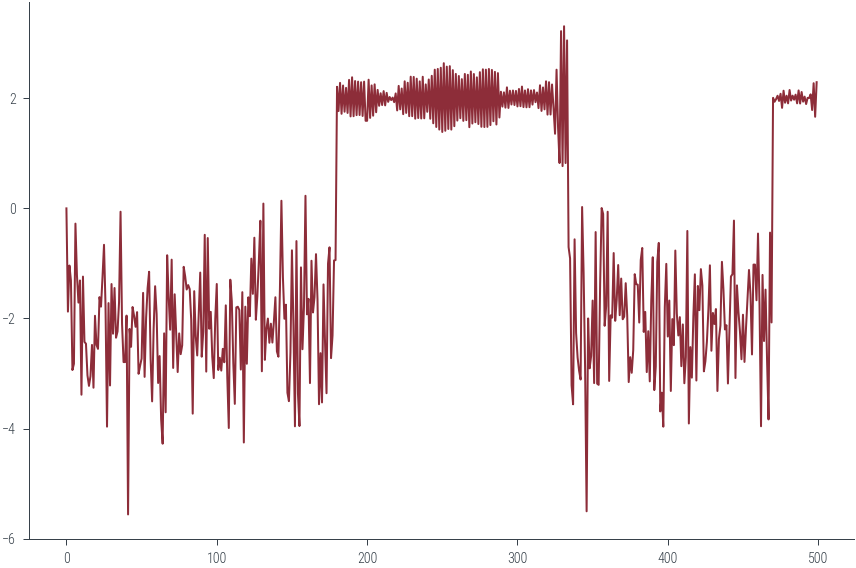

In [66]:
# Trace plot
plt.plot(params_hmc[:500], label='Trace')

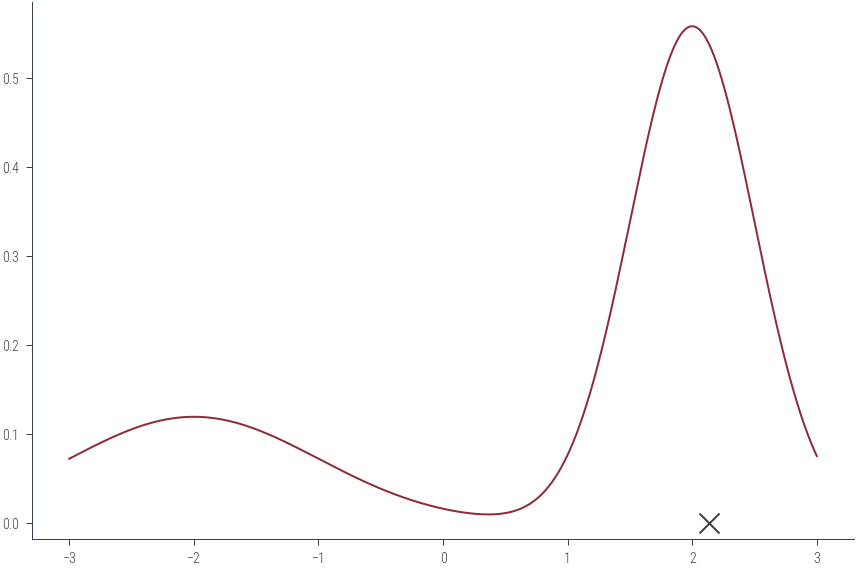

In [70]:
y_lin = torch.exp(mog.log_prob(x_lin))
plot_samples_gif(x_lin, y_lin, params_hmc, '../figures/sampling/mcmc/hamiltorch-samples-mog.gif', frames=300)

In [71]:
def p_tilde(x):
    # normalising constant for standard normal distribution
    Z = torch.sqrt(torch.tensor(2*np.pi))
    return dist.Normal(0, 1).log_prob(x).exp()*Z

def p_tilde_log_prob(x):
    # normalising constant for standard normal distribution
    Z = torch.sqrt(torch.tensor(2*np.pi))
    return dist.Normal(0, 1).log_prob(x) + torch.log(Z)

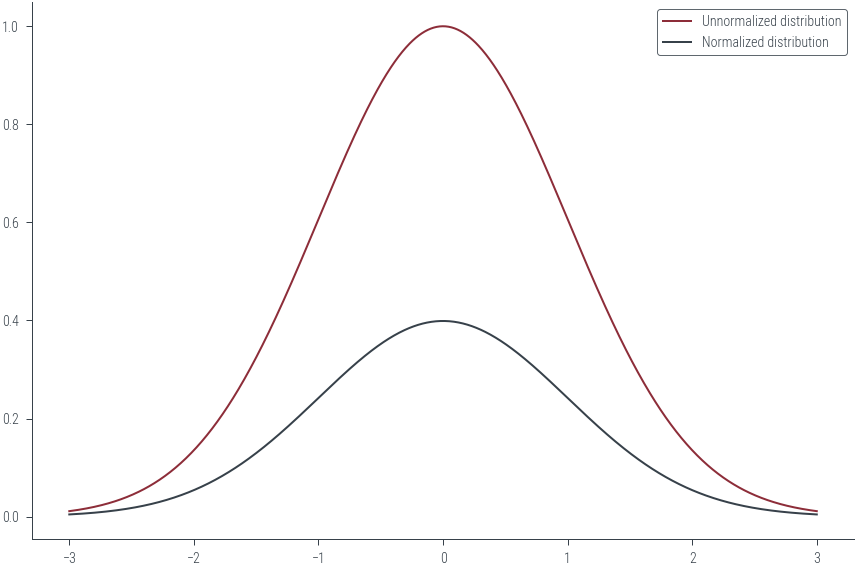

In [73]:
# Plot unnormalized distribution
x_lin = torch.linspace(-3, 3, 1000)
y_lin = p_tilde(x_lin)
plt.plot(x_lin, y_lin, label='Unnormalized distribution')
# Plot normalized distribution
plt.plot(x_lin, dist.Normal(0, 1).log_prob(x_lin).exp(), label='Normalized distribution')
plt.legend()

In [74]:
# HMC over unnormalized distribution

# Logprob function to be passed to Hamiltorch sampler
def logprob(x):
    return p_tilde_log_prob(x)


tensor([0.])

In [75]:
# HMC
x0 = torch.tensor([0.0])
num_samples = 5000
step_size = 0.3
num_steps_per_sample = 5
hamiltorch.set_random_seed(123)

params_hmc = hamiltorch.sample(log_prob_func=logprob, params_init=x0,
                                    num_samples=num_samples, step_size=step_size,
                                    num_steps_per_sample=num_steps_per_sample)

params_hmc = torch.tensor(params_hmc)

Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples   | Samples/sec
0d:00:00:10 | 0d:00:00:00 | #################### | 5000/5000 | 477.15       
Acceptance Rate 0.99


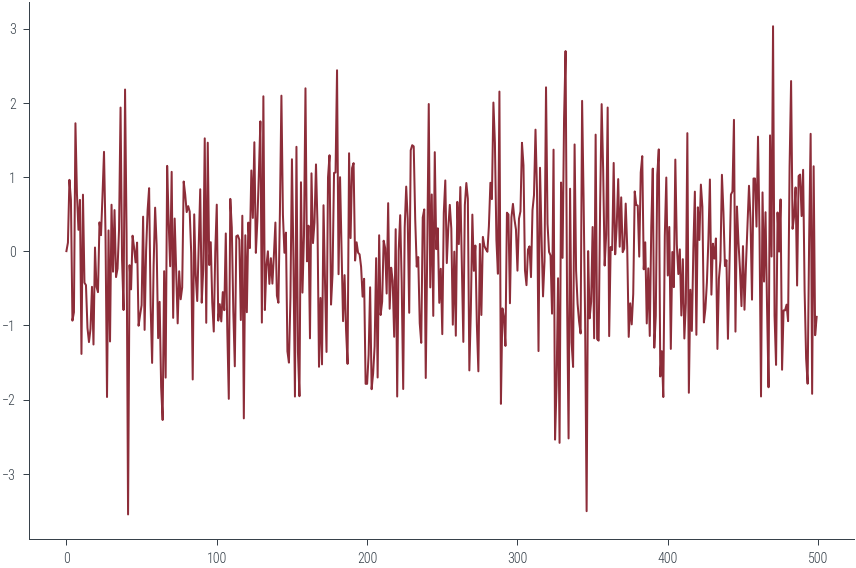

In [76]:
# Trace plot
plt.plot(params_hmc[:500], label='Trace')

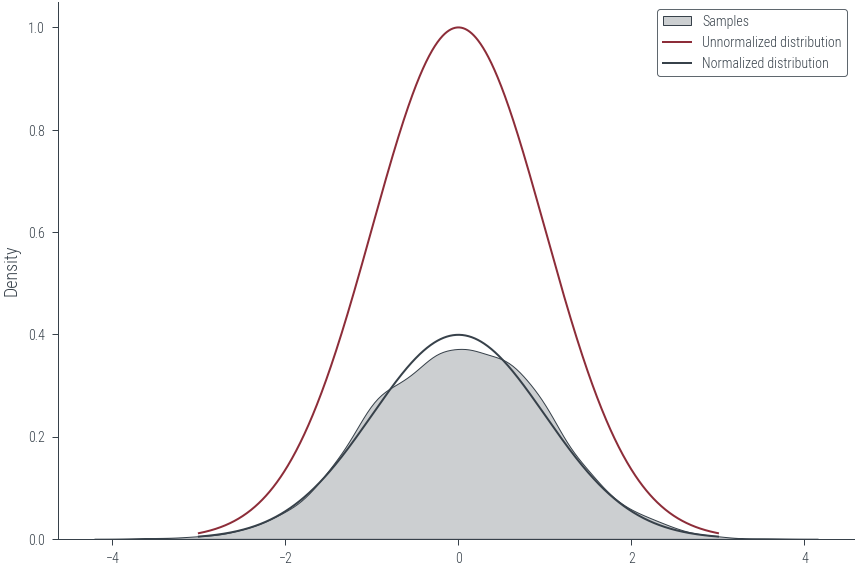

In [77]:
# KDE plot
sns.kdeplot(params_hmc.detach().numpy(), label='Samples', shade=True, color='C1')
plt.plot(x_lin, y_lin, label='Unnormalized distribution')
plt.plot(x_lin, dist.Normal(0, 1).log_prob(x_lin).exp(), label='Normalized distribution')
plt.legend()

In [81]:
# Coin toss

prior = dist.Beta(1, 1)
data = torch.tensor([1.0, 1.0, 1.0, 0.0, 0.0])
n = len(data)

def log_prior(theta):
    return prior.log_prob(theta)

def log_likelihood(theta):
    return dist.Bernoulli(theta).log_prob(data).sum()

def negative_log_joint(theta):
    return (log_prior(theta) + log_likelihood(theta))


In [103]:
def run_hmc(logprob, x0, num_samples, step_size, num_steps_per_sample):
    params_hmc = hamiltorch.sample(log_prob_func=logprob, params_init=x0,
                                    num_samples=num_samples, step_size=step_size,
                                    num_steps_per_sample=num_steps_per_sample)
    return torch.stack(params_hmc)



In [104]:
try:
    params_hmc_theta = run_hmc(negative_log_joint, torch.tensor([0.5]), 5000, 0.3, 5)
except Exception as e:
    print(e)

Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples   | Samples/sec
0d:00:00:16 | 0d:00:00:00 | #################### | 5000/5000 | 305.55       
Acceptance Rate 0.99


In [105]:
# Let us work instead with logits
def log_prior(logits):
    return prior.log_prob(torch.sigmoid(logits)).sum()

def log_likelihood(logits):
    return dist.Bernoulli(logits=logits).log_prob(data).sum()

def log_joint(logits):
    return (log_prior(logits) + log_likelihood(logits))

In [118]:
params_hmc_logits = run_hmc(log_joint, torch.tensor([0.0]), 1000, 0.3, 5)

Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples   | Samples/sec
0d:00:00:03 | 0d:00:00:00 | #################### | 1000/1000 | 270.44       
Acceptance Rate 0.99


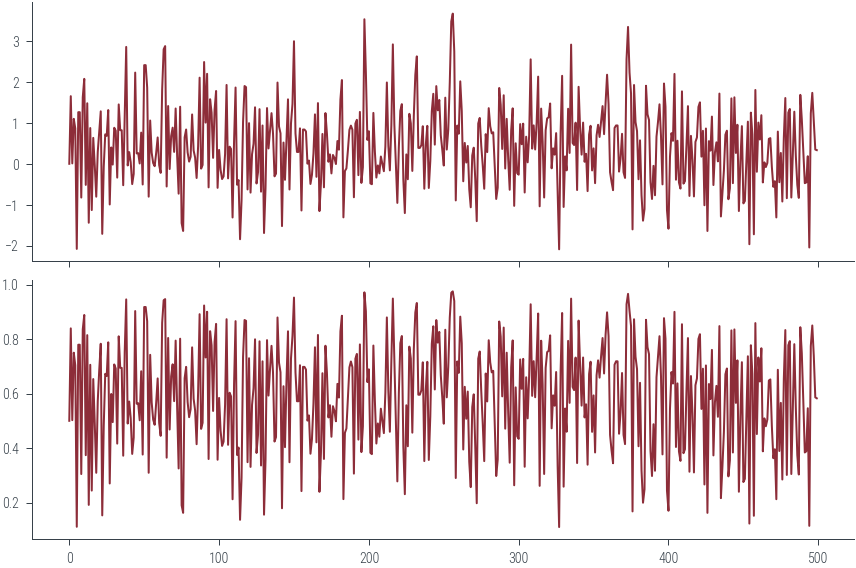

In [119]:
fig, ax = plt.subplots(nrows=2, sharex=True)
ax[0].plot(params_hmc_logits[:500], label='Trace')
ax[1].plot(torch.sigmoid(params_hmc_logits[:500]), label='Trace')

In [120]:
params_hmc_logits[:, 0]

tensor([ 0.0000e+00,  1.6534e+00,  9.6122e-03,  1.0988e+00,  8.6559e-01,
        -2.0808e+00,  1.2617e+00,  1.2617e+00, -8.2547e-01,  1.6278e+00,
         2.0763e+00, -5.1573e-01,  1.4796e+00, -1.4413e+00,  8.7425e-01,
        -1.1314e+00,  6.3342e-01, -3.6684e-02, -8.0399e-01,  2.9092e-01,
         7.8311e-01,  1.2826e+00, -1.7128e+00, -7.3525e-02,  7.2005e-01,
         6.8356e-01,  1.3137e+00, -9.9467e-01,  3.9936e-01, -1.9222e-02,
         8.8107e-01,  8.0997e-01, -3.3786e-01,  1.4515e+00,  8.2083e-01,
         8.2083e-01, -5.2393e-01,  1.1097e+00,  2.8575e+00, -3.9971e-02,
         2.8476e-01,  4.0993e-02, -4.9601e-01, -2.4742e-01,  2.2298e+00,
         2.5214e-01,  2.6092e-01,  7.6723e-03,  7.6258e-01, -5.0583e-01,
         2.4118e+00,  2.4118e+00,  1.8629e+00, -8.0357e-01,  1.0577e+00,
         2.7093e-01,  1.7729e-02, -5.8743e-02,  2.6657e-01,  6.4403e-01,
        -3.1467e-02, -2.2159e-01,  1.8147e+00,  2.7993e+00,  2.8776e+00,
        -5.5522e-01,  1.4121e+00, -1.2795e-01,  6.7

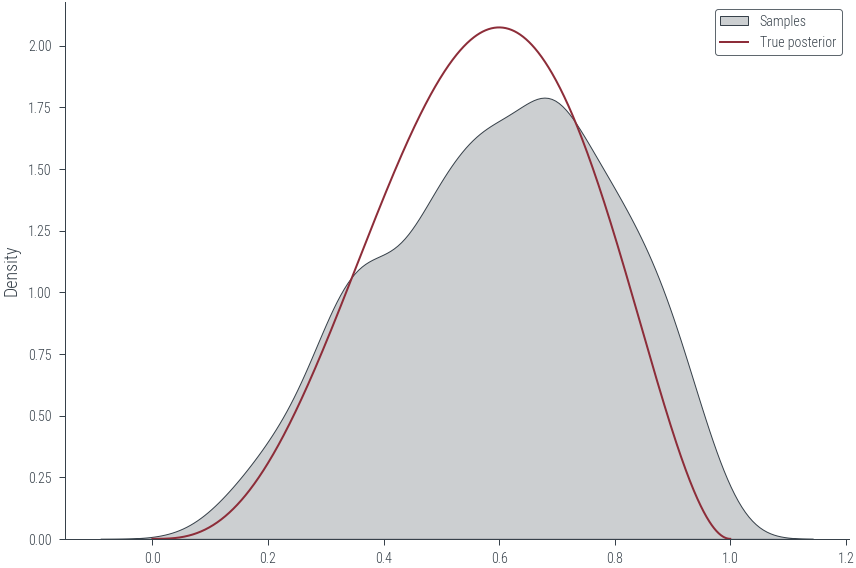

In [121]:
# Plot posterior KDE using arviz

sns.kdeplot(torch.sigmoid(params_hmc_logits[:, 0]).detach().numpy(), label='Samples', shade=True, color='C1')

# True posterior
x_lin = torch.linspace(0, 1, 1000)
y_lin = dist.Beta(1+3, 1+2).log_prob(x_lin).exp()
plt.plot(x_lin, y_lin, label='True posterior')
plt.legend()

Text(0, 0.5, 'y')

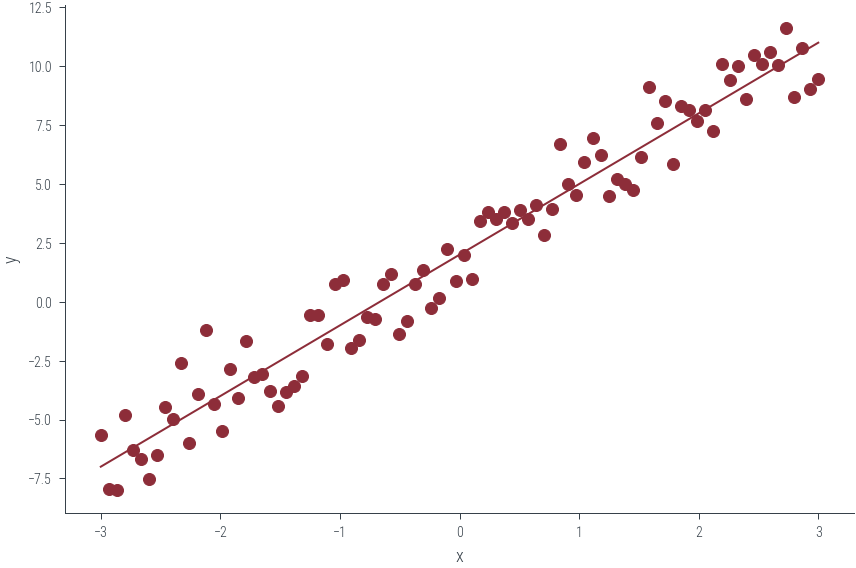

In [100]:
# Linear regression for 1 dimensional input using HMC

x_lin = torch.linspace(-3, 3, 90)
theta_0_true = torch.tensor([2.0])
theta_1_true = torch.tensor([3.0])
f = lambda x: theta_0_true + theta_1_true * x
eps = torch.randn_like(x_lin) *1.0
y_lin = f(x_lin) + eps

plt.scatter(x_lin, y_lin, label='Data', color='C0')
plt.plot(x_lin, f(x_lin), label='Ground truth')
plt.xlabel('x')
plt.ylabel('y')

In [101]:
# Esimate theta_0, theta_1 using HMC assuming noise variance is known to be 1
def logprob(theta):
    y_pred = theta[0] + x_lin * theta[1]
    return dist.Normal(y_pred, 1).log_prob(y_lin).sum()

def log_prior(theta):
    return dist.Normal(0, 1).log_prob(theta).sum()

def log_posterior(theta):
    return logprob(theta) + log_prior(theta)

In [102]:
params_hmc_lin_reg = run_hmc(log_posterior, torch.tensor([0.0, 0.0]), 1000, 0.3, 5)

Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples   | Samples/sec
0d:00:00:03 | 0d:00:00:00 | #################### | 1000/1000 | 265.34       
Acceptance Rate 0.00


ValueError: only one element tensors can be converted to Python scalars

In [26]:
# Initial state
theta_0_init = torch.tensor([-2.0])
theta_1_init = torch.tensor([2.0])
x0 = torch.cat([theta_0_init, theta_1_init])
num_samples = 500

params_hmc = hamiltorch.sample(log_prob_func=log_posterior, params_init=x0,
                                 num_samples=num_samples, step_size=0.1,
                                    num_steps_per_sample=5)


Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 500/500 | 263.99       
Acceptance Rate 0.80


In [27]:
params_hmc = torch.stack(params_hmc)

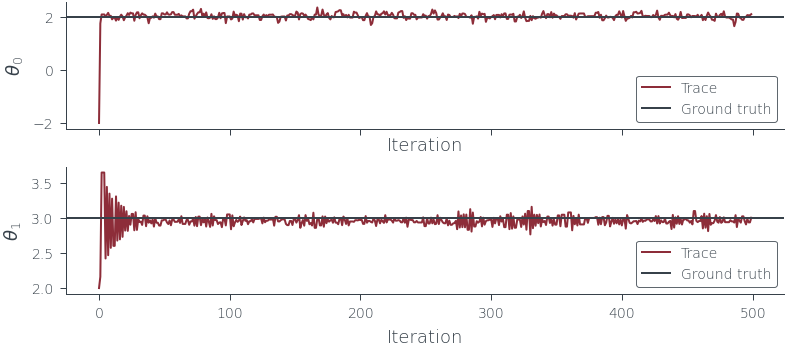

In [28]:
# Plot the traces corresponding to the two parameters
fig, axes = plt.subplots(2, 1, sharex=True)

for i, param_vals in enumerate(params_hmc.T):
    axes[i].plot(param_vals, label='Trace')
    axes[i].set_xlabel('Iteration')
    axes[i].set_ylabel(fr'$\theta_{i}$')

# Plot the true values as well
for i, param_vals in enumerate([theta_0_true, theta_1_true]):
    axes[i].axhline(param_vals.numpy(), color='C1', label='Ground truth')
    axes[i].legend()

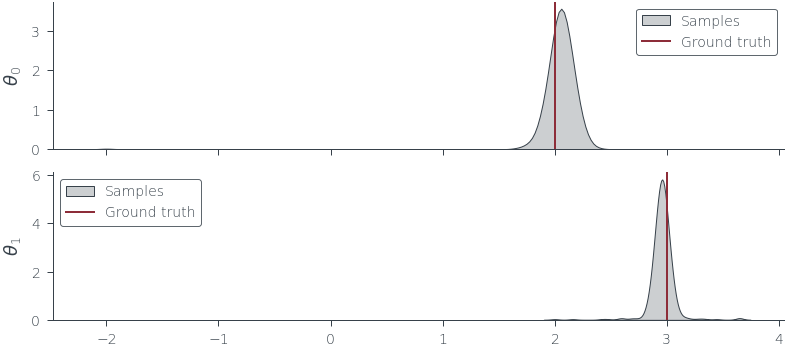

In [29]:
# Plot KDE of the samples for the two parameters
fig, axes = plt.subplots(2, 1, sharex=True)

for i, param_vals in enumerate(params_hmc.T):
    sns.kdeplot(param_vals.detach().numpy(), label='Samples', shade=True, color='C1', ax=axes[i])
    axes[i].set_ylabel(fr'$\theta_{i}$')

# Plot the true values as well
for i, param_vals in enumerate([theta_0_true, theta_1_true]):
    axes[i].axvline(param_vals.numpy(), color='C0', label='Ground truth')
    axes[i].legend()

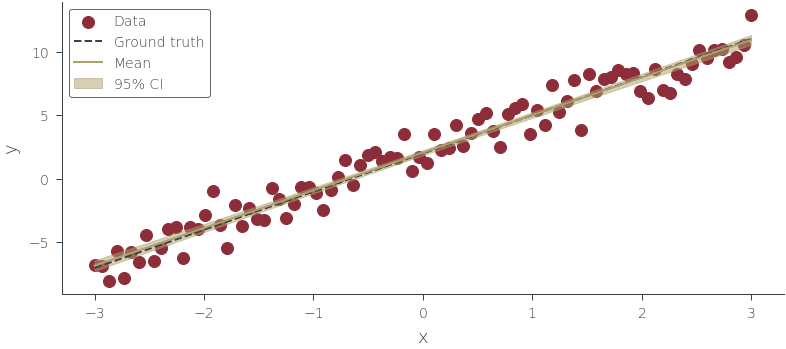

In [30]:
# Plot the posterior predictive distribution
plt.figure()
plt.scatter(x_lin, y_lin, label='Data', color='C0')
plt.plot(x_lin, f(x_lin), label='Ground truth', color='C1', linestyle='--')
plt.xlabel('x')
plt.ylabel('y')

# Get posterior samples. Thin first 100 samples to remove burn-in
posterior_samples = params_hmc[100:]
y_hat = posterior_samples[:, 0].unsqueeze(1) + x_lin * posterior_samples[:, 1].unsqueeze(1)

# Plot mean and 95% confidence interval

plt.plot(x_lin, y_hat.mean(axis=0), label='Mean', color='C2')
plt.fill_between(x_lin, y_hat.mean(axis=0) - 2 * y_hat.std(axis=0), y_hat.mean(axis=0) + 2 * y_hat.std(axis=0), alpha=0.5, label='95% CI', color='C2')
plt.legend()

In [125]:
# Learn the noise variance as well
def logprob(theta):
    intercept, slope, log_noise = theta
    y_pred = intercept + x_lin * slope
    return dist.Normal(y_pred, torch.exp(log_noise)).log_prob(y_lin).sum()

# Initial state
theta_0_init = torch.tensor([-2.0])
theta_1_init = torch.tensor([2.0])
log_noise_init = torch.tensor([0.1])

x0 = torch.cat([theta_0_init, theta_1_init, log_noise_init])
num_samples = 5000

params_hmc = hamiltorch.sample(log_prob_func=logprob, params_init=x0,
                                    num_samples=num_samples, step_size=0.1,
                                    num_steps_per_sample=5)

params_hmc = torch.stack(params_hmc)



Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples   | Samples/sec
0d:00:00:14 | 0d:00:00:00 | #################### | 5000/5000 | 349.16       
Acceptance Rate 0.95


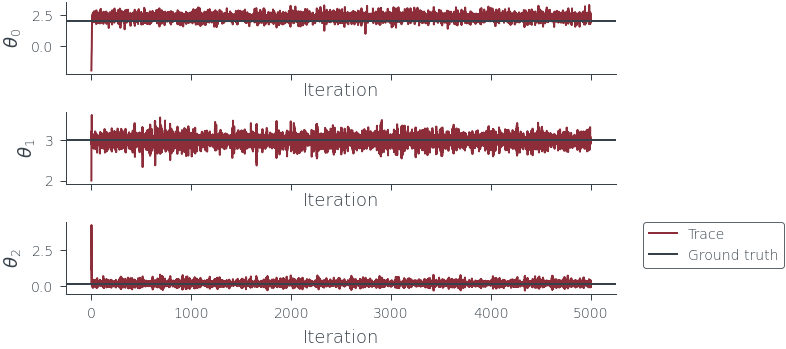

In [128]:
# Plot the traces corresponding to the three parameters
fig, axes = plt.subplots(3, 1, sharex=True)

for i, param_vals in enumerate(params_hmc.T):
    axes[i].plot(param_vals, label='Trace')
    axes[i].set_xlabel('Iteration')
    axes[i].set_ylabel(fr'$\theta_{i}$')

# Plot the true values as well
for i, param_vals in enumerate([theta_0_true, theta_1_true, torch.log(eps.std())]):
    axes[i].axhline(param_vals.numpy(), color='C1', label='Ground truth')

# legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)


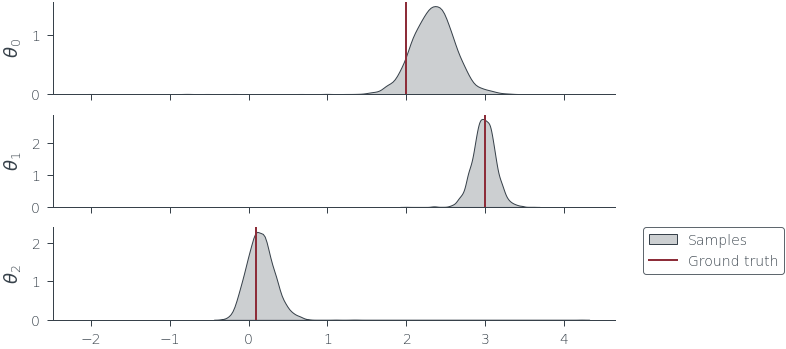

In [129]:
# Plot KDE of the samples for the three parameters
fig, axes = plt.subplots(3, 1, sharex=True)

for i, param_vals in enumerate(params_hmc.T):
    sns.kdeplot(param_vals.detach().numpy(), label='Samples', shade=True, color='C1', ax=axes[i])
    axes[i].set_ylabel(fr'$\theta_{i}$')

# Plot the true values as well
for i, param_vals in enumerate([theta_0_true, theta_1_true, torch.log(eps.std())]):
    axes[i].axvline(param_vals.numpy(), color='C0', label='Ground truth')

# legend outside the plot   
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

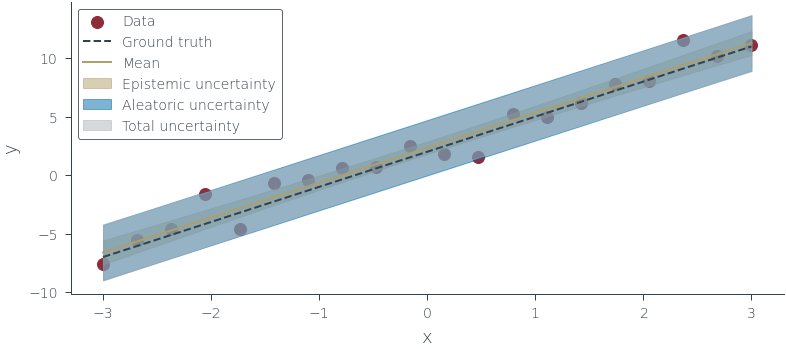

In [134]:
# Plot the posterior predictive distribution
plt.figure()
plt.scatter(x_lin, y_lin, label='Data', color='C0')
plt.plot(x_lin, f(x_lin), label='Ground truth', color='C1', linestyle='--')
plt.xlabel('x')
plt.ylabel('y')

# Get posterior samples. Thin first 100 samples to remove burn-in
posterior_samples = params_hmc[100:]
y_hat = posterior_samples[:, 0].unsqueeze(1) + x_lin * posterior_samples[:, 1].unsqueeze(1)

# Plot mean and 95% confidence interval
plt.plot(x_lin, y_hat.mean(axis=0), label='Mean', color='C2')
plt.fill_between(x_lin, y_hat.mean(axis=0) - 2 * y_hat.std(axis=0), y_hat.mean(axis=0) + 2 * y_hat.std(axis=0), 
                 alpha=0.5, label='Epistemic uncertainty', color='C2')

# Plot aleatoric uncertainty
plt.fill_between(x_lin, y_hat.mean(axis=0) - 2 * torch.exp(posterior_samples[:, 2]).mean(axis=0),
                    y_hat.mean(axis=0) + 2 * torch.exp(posterior_samples[:, 2]).mean(axis=0),
                    alpha=0.5, label='Aleatoric uncertainty', color='C3')

# Plot total uncertainty
plt.fill_between(x_lin, y_hat.mean(axis=0) - 2 * torch.sqrt(torch.exp(posterior_samples[:, 2]).mean(axis=0) + y_hat.std(axis=0)**2),
                    y_hat.mean(axis=0) + 2 * torch.sqrt(torch.exp(posterior_samples[:, 2]).mean(axis=0) + y_hat.std(axis=0)**2),
                    alpha=0.5, label='Total uncertainty', color='C4')



plt.legend()

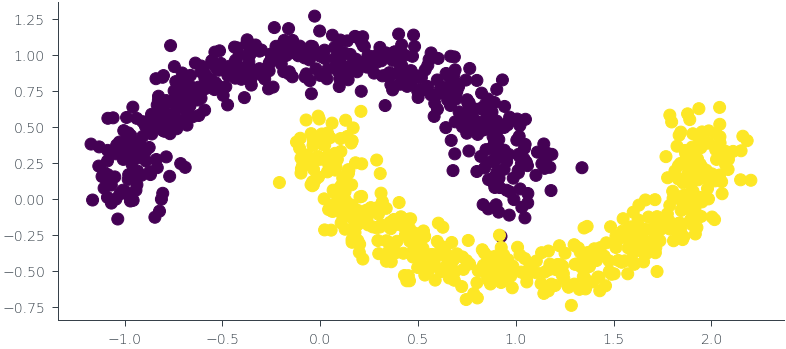

In [38]:
### Bayesian Logistic Regression

from sklearn.datasets import make_moons

# Generate data
x, y = make_moons(n_samples=1000, noise=0.1, random_state=0)

plt.scatter(x[:, 0], x[:, 1], c=y)

x = torch.tensor(x).float()
y = torch.tensor(y).float()

In [39]:
def log_prior_logistic(theta):
    return dist.Normal(0, 1).log_prob(theta).sum()

    

def log_likelihood_logistic(theta):
    theta_0, theta_1, theta_2 = theta
    logits = theta_0 + theta_1 * x[:, 0] + theta_2 * x[:, 1]
    return dist.Bernoulli(logits=logits).log_prob(y).sum()

def log_joint_logistic(theta):
    return log_likelihood_logistic(theta) + log_prior_logistic(theta)


In [40]:
# Initial state
theta_0_init = torch.tensor([-2.0])
theta_1_init = torch.tensor([2.0])
theta_2_init = torch.tensor([3.0])

x0 = torch.cat([theta_0_init, theta_1_init, theta_2_init])

num_samples = 500

params_hmc = hamiltorch.sample(log_prob_func=log_joint_logistic, params_init=x0,
                                    num_samples=num_samples, step_size=0.1,
                                    num_steps_per_sample=5)





Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 500/500 | 258.45       
Acceptance Rate 0.97


In [42]:
params_hmc = torch.stack(params_hmc)

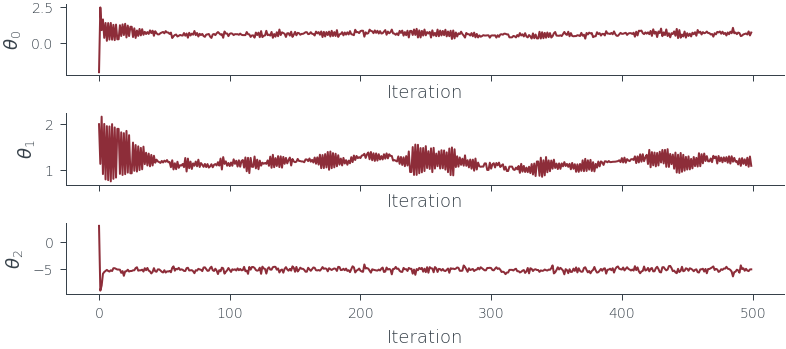

In [43]:
# Plot the traces corresponding to the three parameters
fig, axes = plt.subplots(3, 1, sharex=True)

for i, param_vals in enumerate(params_hmc.T):
    axes[i].plot(param_vals, label='Trace')
    axes[i].set_xlabel('Iteration')
    axes[i].set_ylabel(fr'$\theta_{i}$')


In [61]:
# Find MAP estimate using optimization of the log joint

def neg_log_joint_logistic(theta):
    return -log_joint_logistic(theta)

theta_0_init = torch.tensor([-2.0], requires_grad=True)
theta_1_init = torch.tensor([2.0], requires_grad=True)
theta_2_init = torch.tensor([3.0], requires_grad=True)


optimizer = torch.optim.Adam([theta_0_init, theta_1_init, theta_2_init], lr=0.01)

for i in range(1000):
    optimizer.zero_grad()
    x0 = torch.cat([theta_0_init, theta_1_init, theta_2_init])

    loss = neg_log_joint_logistic(x0)
    loss.backward()
    optimizer.step()
    print(loss.item())

theta_0_map = theta_0_init
theta_1_map = theta_1_init
theta_2_map = theta_2_init



1098.2039794921875
1094.0623779296875
1089.9691162109375
1085.9251708984375
1081.9307861328125
1077.9866943359375
1074.09326171875
1070.2509765625
1066.4599609375
1062.7200927734375
1059.0313720703125
1055.3936767578125
1051.8065185546875
1048.269287109375
1044.78125
1041.341796875
1037.94970703125
1034.603759765625
1031.302734375
1028.04541015625
1024.830078125
1021.6551513671875
1018.5191040039062
1015.4199829101562
1012.3562622070312
1009.3262939453125
1006.3283081054688
1003.3605346679688
1000.421875
997.5106201171875
994.62548828125
991.7653198242188
988.9291381835938
986.1158447265625
983.3247680664062
980.5552368164062
977.806884765625
975.0789184570312
972.3712768554688
969.6836547851562
967.015869140625
964.3678588867188
961.7394409179688
959.1307373046875
956.5415649414062
953.971923828125
951.4219360351562
948.8914794921875
946.3806762695312
943.8890991210938
941.4169921875
938.9642333984375
936.530517578125
934.115966796875
931.719970703125
929.3426513671875
926.98370361328

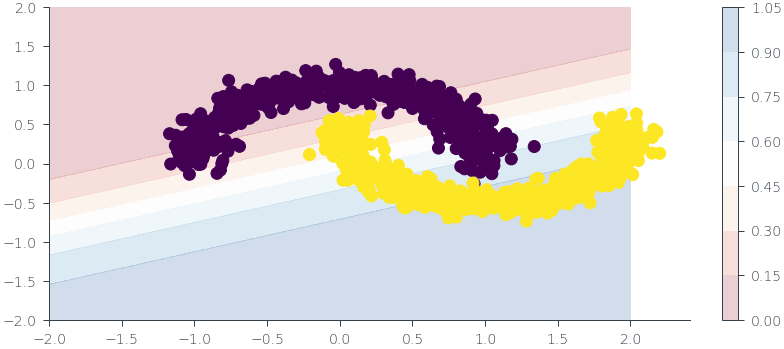

In [62]:
# Make the contour plot of predictive distribution
# Create a grid of points

x1 = np.linspace(-2, 2, 100)
x2 = np.linspace(-2, 2, 100)
x1, x2 = np.meshgrid(x1, x2)

# Flatten the grid to a list of (x1, x2) points
x_grid = np.vstack([x1.ravel(), x2.ravel()]).T

# Convert to torch tensor
x_grid = torch.tensor(x_grid).float()

# Compute predictive mean using the MAP estimate

y_hat = theta_0_map + theta_1_map * x_grid[:, 0] + theta_2_map * x_grid[:, 1]

with torch.no_grad():
    y_hat = torch.sigmoid(y_hat)

y_hat = y_hat.numpy().reshape(x1.shape)

# Plot the contour
plt.figure()

plt.contourf(x1, x2, y_hat, cmap='RdBu', alpha=0.2)
plt.colorbar()

# Plot the data
plt.scatter(x[:, 0], x[:, 1], c=y)




In [63]:
y_hat.reshape(100, 100)

array([[9.7135979e-01, 9.7270298e-01, 9.7398496e-01, ..., 9.9975580e-01,
        9.9976760e-01, 9.9977881e-01],
       [9.6787727e-01, 9.6937859e-01, 9.7081202e-01, ..., 9.9972516e-01,
        9.9973840e-01, 9.9975103e-01],
       [9.6398699e-01, 9.6566373e-01, 9.6726513e-01, ..., 9.9969065e-01,
        9.9970549e-01, 9.9971968e-01],
       ...,
       [3.5059865e-04, 3.6835304e-04, 3.8700618e-04, ..., 4.0619463e-02,
        4.2589553e-02, 4.4650748e-02],
       [3.1148057e-04, 3.2725467e-04, 3.4382736e-04, ..., 3.6250271e-02,
        3.8016848e-02, 3.9865952e-02],
       [2.7672586e-04, 2.9074043e-04, 3.0546452e-04, ..., 3.2335207e-02,
        3.3917706e-02, 3.5574805e-02]], dtype=float32)

In [164]:
# Simple BNN in Hamiltorch
import torch.nn as nn


# Define the model
class BNN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim):
        super(BNN, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        
        self.fc1 = nn.Linear(self.input_dim, self.hidden_dim)
        self.fc2 = nn.Linear(self.hidden_dim, self.output_dim)
        
    def forward(self, x):
        x = nn.ReLU()(self.fc1(x))
        x = self.fc2(x)
        return x
    

In [165]:
net = BNN(input_dim=1, output_dim=1, hidden_dim=10)
net

BNN(
  (fc1): Linear(in_features=1, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=1, bias=True)
)

In [166]:
net(torch.tensor([1.0]))

tensor([0.1153], grad_fn=<AddBackward0>)